In [2]:
from unsupervised_topic_segmentation import core, eval, types, dataset
import create_test_data
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings

In [4]:
with open('data/transcripts_with_embeds.pickle', 'rb') as handle:
    test_data = pickle.load(handle)



In [8]:
test_data.columns

Index(['level_0', 'index', 'meeting_id', 'caption', 'label', 'topic_desc',
       'has_topic_desc', 'embedding', 'end_time', 'start_time'],
      dtype='object')

In [ ]:
test_data=test_data.drop(columns=['level_0','index'])
test_data = dataset.add_durations(test_data)  # "duration" column is just number of words
test_data = dataset.preprocessing(test_data,min_caption_len=20)  # note that this adds (old) `index` column, but topic_segmentation uses actual index

In [19]:
example_data = test_data[test_data.meeting_id=='AMI_0']

In [20]:
new_algorithm = types.BERTSegmentation(
    sentence_comparison_window=50,
    text_tiling=types.NewSegmentation(
        stdevs=1))

new_algorithm

BERTSegmentation(SENTENCE_COMPARISON_WINDOW=50, TEXT_TILING=NewSegmentation(STDEVS=1))

In [21]:
eval.eval_topic_segmentation(
    topic_segmentation_algorithm=new_algorithm,
    input_df=test_data,
    verbose=False)

/home/opinney/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/opinney/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/opinney/.local/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/opinney/.local/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/opinney/.local/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'average_Pk_': 0.455364745110001, 'average_windiff_': 0.4777037276548979}

In [22]:
core.topic_segmentation(
    topic_segmentation_algorithm=new_algorithm,
    df=example_data,
    embedding_col_name="not-used!")

No embedding column found, running RoBERTa inference.


{'AMI_0': [104, 120, 130, 189, 195]}

In [23]:
core.topic_segmentation(
    topic_segmentation_algorithm=new_algorithm,
    df=example_data,
    embedding_col_name="embedding")

{'AMI_0': [100, 114, 185]}

In [24]:
len(example_data)

251

In [25]:
example_data[example_data.label.diff()==1]

,index,meeting_id,caption,label,topic_desc,has_topic_desc,embedding,end_time,start_time
8,8,AMI_0,let's talk about the interface concept .,1,industrial designer presentation,True,"[[tensor(0.0637, dtype=torch.float64), tensor(...",65,56
42,42,AMI_0,", at first we will I will f say something a...",2,interface specialist presentation,True,"[[tensor(0.0759, dtype=torch.float64), tensor(...",481,462
54,54,AMI_0,"Now , another picture .",3,marketing expert presentation,True,"[[tensor(0.0348, dtype=torch.float64), tensor(...",648,643
65,65,AMI_0,"Now , w we have to decide",4,discussion,True,"[[tensor(0.0764, dtype=torch.float64), tensor(...",777,770
243,243,AMI_0,we have one minute .,5,closing,True,"[[tensor(-0.0206, dtype=torch.float64), tensor...",2525,2518


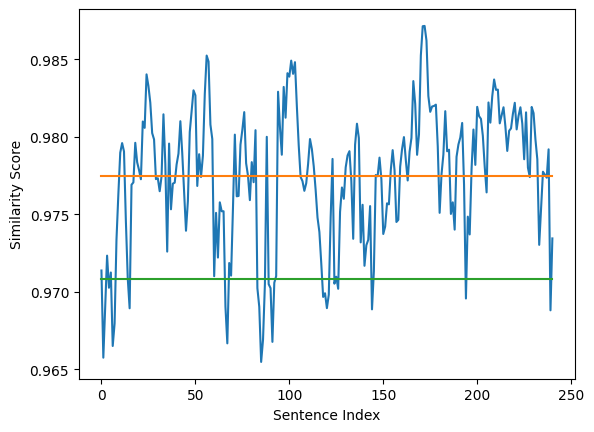

[11, 14, 16, 25, 77, 95, 101, 130, 134, 136, 154, 204, 249]


{'AMI_0': [11, 14, 16, 25, 77, 95, 101, 130, 134, 136, 154, 204, 249]}

In [26]:
algorithm = types.BERTSegmentation(
    sentence_comparison_window=5,
    text_tiling=types.NewSegmentation(
        stdevs=1.5))

core.topic_segmentation(
    topic_segmentation_algorithm=algorithm,
    df=example_data,
    embedding_col_name="embedding",
    verbose=True)

In [ ]:
comparison_windows=[40,50,70,90]
stds=[1,2,2.5,3,3.5]
model_hyperparams=[]
pks = []
windiffs =[]
segmentations = []

new_algorithm = types.BERTSegmentation(
    sentence_comparison_window=50,
    text_tiling=types.NewSegmentation(
        stdevs=1))

for window in comparison_windows:
    for std in stds:
        algorithm = types.BERTSegmentation(
            sentence_comparison_window=window,text_tiling=types.NewSegmentation(stdevs=std))
        model_hyperparams.append((window,std))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            results, segmentation = eval.eval_topic_segmentation(
                topic_segmentation_algorithm=algorithm,input_df=test_data,return_segmentation=True)
        pks.append(results['average_Pk_'])
        windiffs.append(results['average_windiff_'])
        segmentations.append(segmentation)

In [22]:
segmentation_means = [np.mean([len(x) for x in segmentations[i].values()]) for i in range(len(segmentations))]
segmentation_stds = [np.std([len(x) for x in segmentations[i].values()]) for i in range(len(segmentations))]

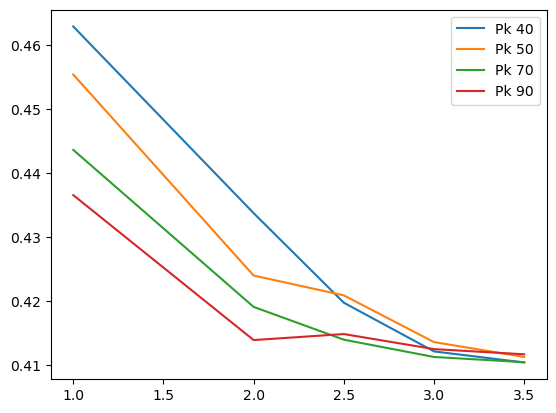

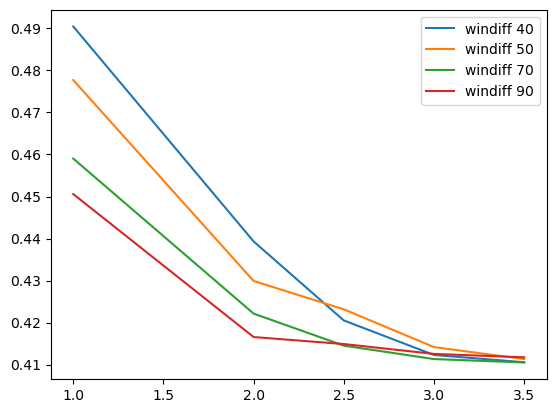

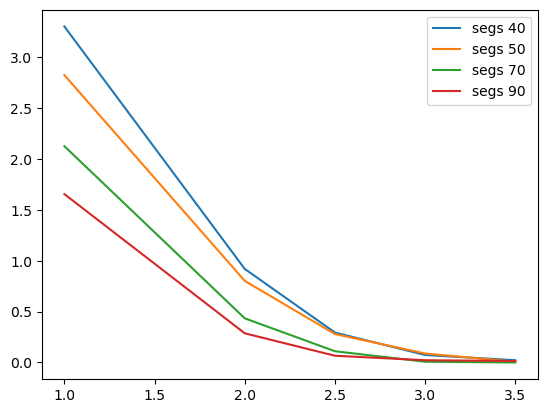

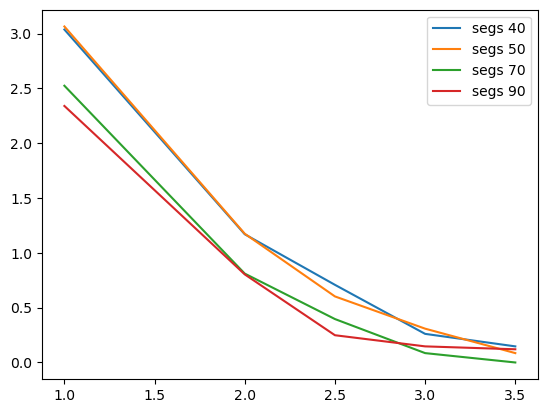

In [25]:
legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,pks[i*len(stds):len(stds)*(i+1)])
    legend.append(f'Pk {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.show()

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,windiffs[i*len(stds):len(stds)*(i+1)])
    legend.append(f'windiff {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.show()

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,segmentation_means[i*len(stds):len(stds)*(i+1)])
    legend.append(f'segs {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.show()

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,segmentation_stds[i*len(stds):len(stds)*(i+1)])
    legend.append(f'segs {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.show()

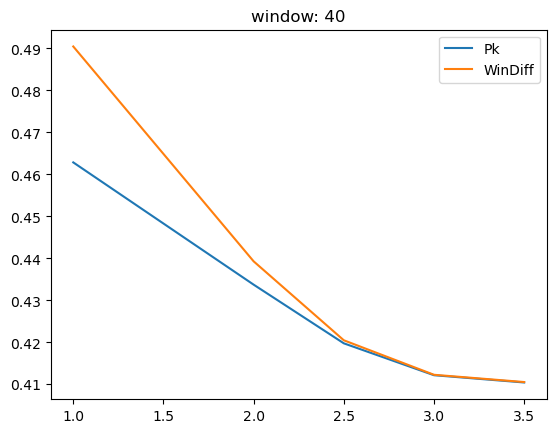

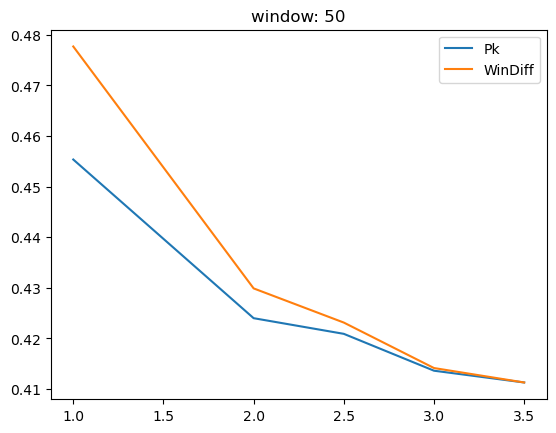

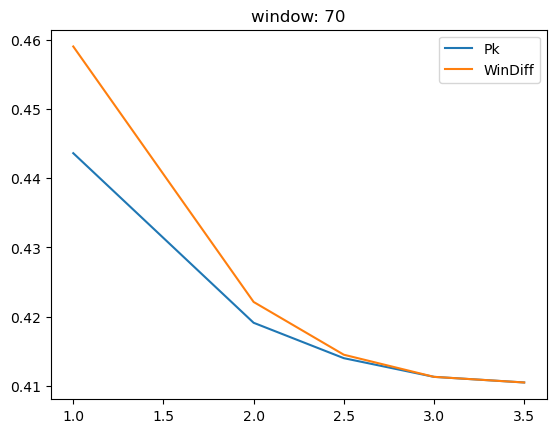

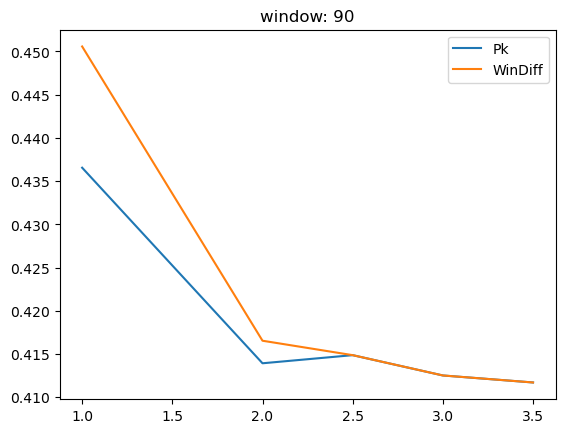

In [13]:
for i in range(0,len(comparison_windows)):
    plt.plot(stds,pks[i*len(stds):len(stds)*(i+1)])
    plt.title(f'window: {model_hyperparams[i*len(stds)][0]}')
    plt.plot(stds,windiffs[i*len(stds):len(stds)*(i+1)])
    plt.title(f'window: {model_hyperparams[i*len(stds)][0]}')
    plt.legend(['Pk','WinDiff'])
    plt.show()

In [26]:
comparison_windows=[10,20,30]
stds=[1,2,2.5,3,3.5]

for window in comparison_windows:
    for std in stds:
        algorithm = types.BERTSegmentation(
            sentence_comparison_window=window,text_tiling=types.NewSegmentation(stdevs=std))
        model_hyperparams.append((window,std))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            results, segmentation = eval.eval_topic_segmentation(
                topic_segmentation_algorithm=algorithm,input_df=test_data,return_segmentation=True)
        pks.append(results['average_Pk_'])
        windiffs.append(results['average_windiff_'])
        segmentations.append(segmentation)

In [27]:
comparison_windows = [40,50,70,90] + comparison_windows

In [29]:
segmentation_means += [np.mean([len(x) for x in segmentations[i].values()]) for i in range(len(segmentations))]
segmentation_stds += [np.std([len(x) for x in segmentations[i].values()]) for i in range(len(segmentations))]

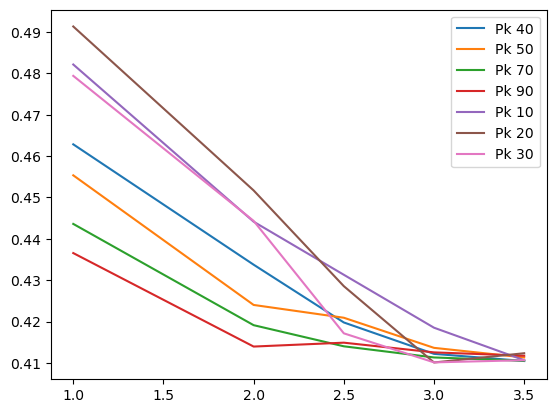

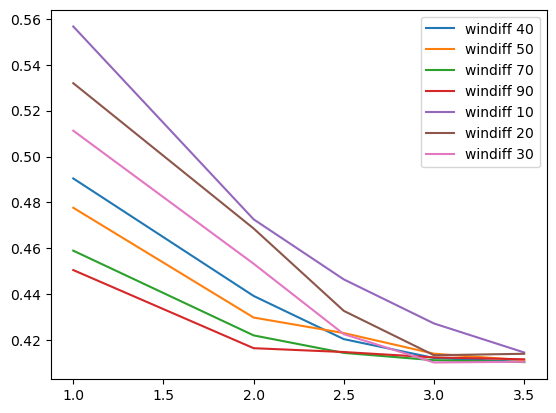

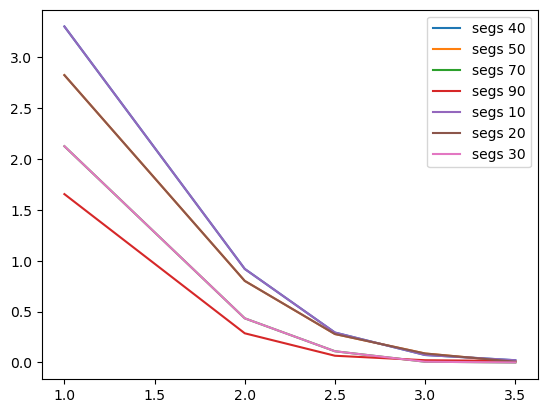

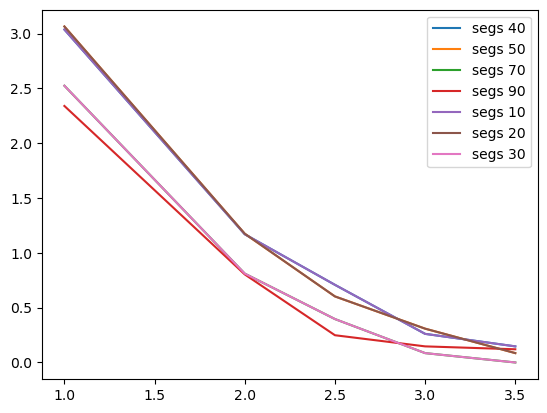

In [30]:
legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,pks[i*len(stds):len(stds)*(i+1)])
    legend.append(f'Pk {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.show()

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,windiffs[i*len(stds):len(stds)*(i+1)])
    legend.append(f'windiff {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.show()

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,segmentation_means[i*len(stds):len(stds)*(i+1)])
    legend.append(f'segs {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.show()

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,segmentation_stds[i*len(stds):len(stds)*(i+1)])
    legend.append(f'segs {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.show()

In [32]:
comparison_windows=[10,30,50,70]
stds=[0.5,1,2,3]
model_hyperparams=[]
pks = []
windiffs =[]
segmentations = []

for window in comparison_windows:
    for std in stds:
        algorithm = types.BERTSegmentation(
            sentence_comparison_window=window,text_tiling=types.NewSegmentation(stdevs=std))
        model_hyperparams.append((window,std))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            results, segmentation = eval.eval_topic_segmentation(
                topic_segmentation_algorithm=algorithm,input_df=test_data,return_segmentation=True)
        pks.append(results['average_Pk_'])
        windiffs.append(results['average_windiff_'])
        segmentations.append(segmentation)

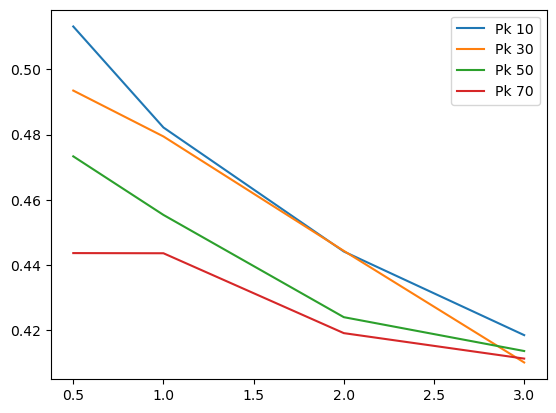

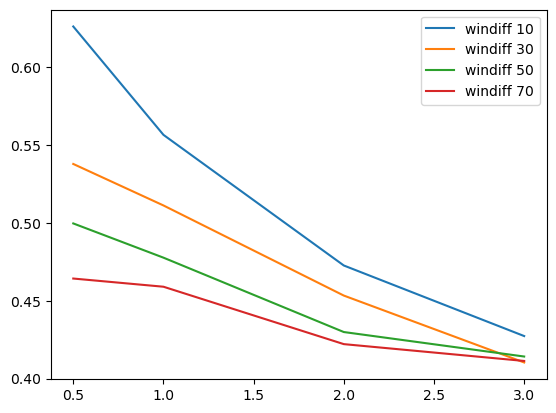

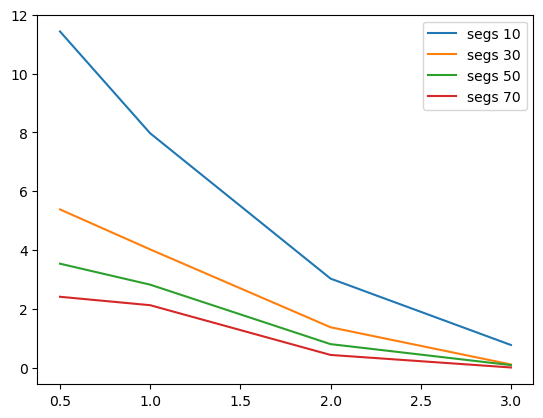

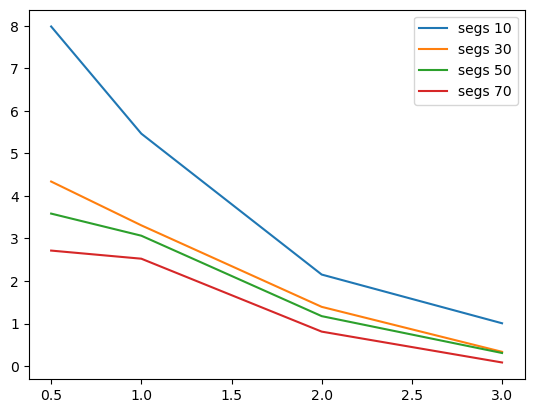

In [33]:
segmentation_means = [np.mean([len(x) for x in segmentations[i].values()]) for i in range(len(segmentations))]
segmentation_stds = [np.std([len(x) for x in segmentations[i].values()]) for i in range(len(segmentations))]

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,pks[i*len(stds):len(stds)*(i+1)])
    legend.append(f'Pk {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.show()

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,windiffs[i*len(stds):len(stds)*(i+1)])
    legend.append(f'windiff {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.show()

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,segmentation_means[i*len(stds):len(stds)*(i+1)])
    legend.append(f'segs {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.show()

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,segmentation_stds[i*len(stds):len(stds)*(i+1)])
    legend.append(f'segs {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.show()

# Artificial Segmentation

In [98]:
import create_test_data

In [146]:
def data_gen(transcript_id=None,doc_count_limit:int=10,sentence_min:int=20):
    results, embedding, labels, topics, doc_count = create_test_data.generate_segment(
        t=test_data.rename(columns={'caption':'sentences','label':'topic_counts'}).groupby(['meeting_id'], as_index = False).agg({
        'sentences':lambda x: list(x),
        'embedding':lambda x: list(x),
        'topic_counts':lambda x: list(x)}),
        embeddings=True, labeled=True,
        doc_count_limit = doc_count_limit, sentence_min = sentence_min)
    if len(labels)==len(results):
        return dataset.add_durations(pd.DataFrame({
                            'meeting_id':[transcript_id]*len(results),
                            'caption':results,
                            'embedding':embedding,
                            'label':labels,
                            'true_label':topics
                            })
                            ,'caption') 
    else:
        return None


def dataset_gen(n_transcripts:int,doc_count_limit:int=10,sentence_min:int=20):
    df=None
    for i in range(n_transcripts):
        temp=data_gen("rand_"+str(i),doc_count_limit,sentence_min)
        if df is None:
            df=temp
        elif temp is not None:
            df=pd.concat([df,temp])
    return df


In [139]:
doc_count_limit = 10
sentence_min = 20
df=dataset_gen(1000,doc_count_limit,sentence_min)
df.columns

,caption,embedding,label,true_label,meeting_id,end_time,start_time
0,Welcome to the what should be the last of the...,"[[tensor(-0.0127, dtype=torch.float64), tensor...",0,0,rand_0,12,0
1,and it looks like we've done a good job here,"[[tensor(0.0123, dtype=torch.float64), tensor(...",0,0,rand_0,24,12
2,and we'll just go through the the final the ...,"[[tensor(0.0432, dtype=torch.float64), tensor(...",0,0,rand_0,38,24
3,the th the the minutes of the last meeting I...,"[[tensor(0.1326, dtype=torch.float64), tensor(...",0,0,rand_0,59,38
4,the th the the next thing we we we'll have a...,"[[tensor(0.0428, dtype=torch.float64), tensor(...",0,0,rand_0,83,59
...,...,...,...,...,...,...,...
413,"Alright , thank you team ,","[[tensor(0.0126, dtype=torch.float64), tensor(...",8,8005,rand_999,5263,5257
414,"you did a great job ,","[[tensor(-0.1168, dtype=torch.float64), tensor...",8,8005,rand_999,5269,5263
415,it was lovely working with you .,"[[tensor(0.0248, dtype=torch.float64), tensor(...",8,8005,rand_999,5276,5269
416,Whooo . Margaritas for everyone .,"[[tensor(0.0068, dtype=torch.float64), tensor(...",8,8005,rand_999,5283,5276


In [143]:
test_data.columns


Index(['index', 'meeting_id', 'caption', 'label', 'topic_desc',
       'has_topic_desc', 'embedding', 'end_time', 'start_time'],
      dtype='object')

In [147]:
doc_count_limit = 6
sentence_min = 20
artificial_data=dataset_gen(1000,doc_count_limit,sentence_min)
artificial_data.columns

Index(['meeting_id', 'caption', 'embedding', 'label', 'true_label', 'end_time',
       'start_time'],
      dtype='object')

In [173]:
artificial_data_small=dataset_gen(10,doc_count_limit,sentence_min)
artificial_data_small.columns

Index(['meeting_id', 'caption', 'embedding', 'label', 'true_label', 'end_time',
       'start_time'],
      dtype='object')

In [180]:
comparison_windows=[10,30,50,70]
stds=[0.5,1,2,3]

comparison_windows=[50]
stds=[1.5,2]

model_hyperparams=[]
pks = []
windiffs =[]
segmentations = []

for window in comparison_windows:
    for std in stds:
        algorithm = types.BERTSegmentation(
            sentence_comparison_window=window,text_tiling=types.NewSegmentation(stdevs=std))
        model_hyperparams.append((window,std))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            results, segmentation = eval.eval_topic_segmentation(
                topic_segmentation_algorithm=algorithm,input_df=artificial_data_small,return_segmentation=True)
        print(results)
        pks.append(results['average_Pk_'])
        windiffs.append(results['average_windiff_'])
        segmentations.append(segmentation)

{'average_Pk_': nan, 'average_windiff_': nan}
{'average_Pk_': nan, 'average_windiff_': nan}


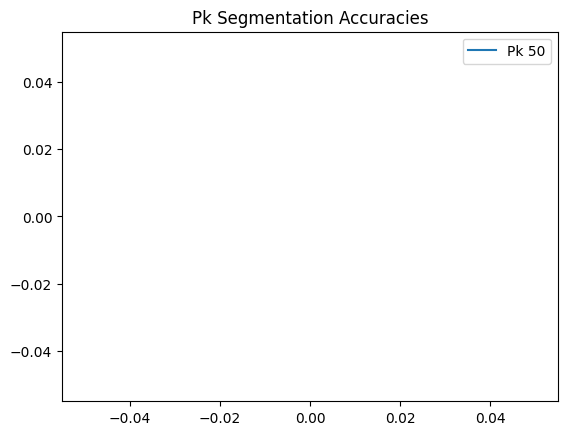

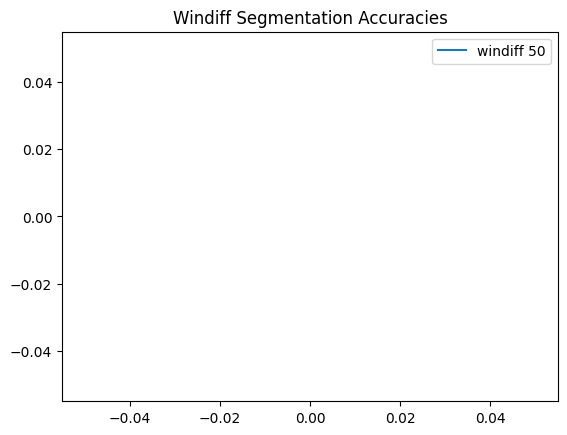

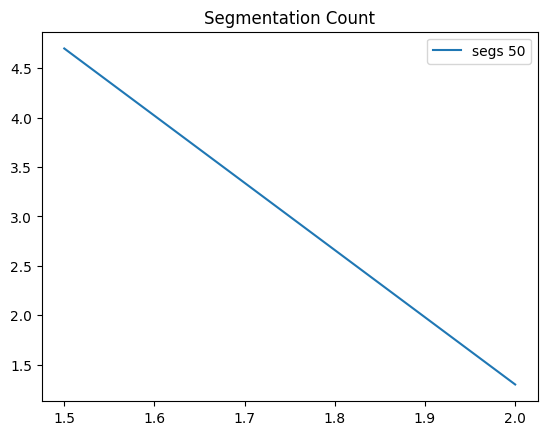

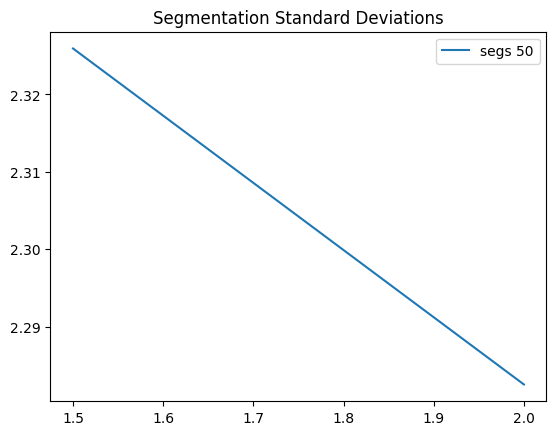

In [177]:
segmentation_means = [np.mean([len(x) for x in segmentations[i].values()]) for i in range(len(segmentations))]
segmentation_stds = [np.std([len(x) for x in segmentations[i].values()]) for i in range(len(segmentations))]

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,pks[i*len(stds):len(stds)*(i+1)])
    legend.append(f'Pk {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.title("Pk Segmentation Accuracies")
plt.show()

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,windiffs[i*len(stds):len(stds)*(i+1)])
    legend.append(f'windiff {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.title("Windiff Segmentation Accuracies")
plt.show()

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,segmentation_means[i*len(stds):len(stds)*(i+1)])
    legend.append(f'segs {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.title("Segmentation Count")
plt.show()

legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,segmentation_stds[i*len(stds):len(stds)*(i+1)])
    legend.append(f'segs {model_hyperparams[i*len(stds)][0]}')
plt.legend(legend)
plt.title("Segmentation Standard Deviations")
plt.show()


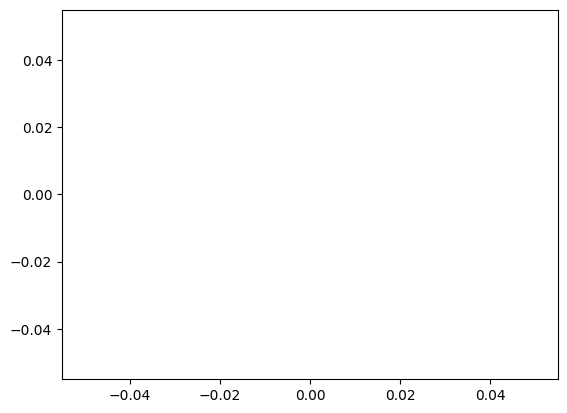

In [151]:
legend = []
for i in range(0,len(comparison_windows)):
    plt.plot(stds,windiffs[i*len(stds):len(stds)*(i+1)])
plt.show()


In [172]:
import statistics
statistics.median([len(x) for x in segmentations[0].values()])

len(segmentations)

16